In [1]:
# Modelo Markowitz Puro
 
#-----------------------------------------------------------------------------
# Importa bibliotecas e define variáveis
#-----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.optimize import Bounds
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, RidgeCV

janela_reb = 126
janela_retornos = 504
janela_indic = 252
custo = 0.0025
str_dir = 'C:/Users/nelly/Desktop/Mestrado Insper/DISSERTAÇÃO/Dissertação/1. Modelo/'

In [2]:
#-----------------------------------------------------------------------------
# Define funções - Otimização de Portfolio Markowitz
#-----------------------------------------------------------------------------

def get_port(mu,cov,wu,gamma):
    
    N_t = df_Retornos.shape[1]
    
    w0 = np.ones(N_t)/N_t

    sharpe = lambda w : -((1+ w.dot(np.array(mu)) - np.abs(w-wu).sum()*custo)**(1-gamma))/(1-gamma)
        
    eq_cons = ({'type': 'eq', 'fun': lambda w: w.sum() - 1},
               {'type': 'ineq', 'fun': lambda w: w + 0.2},
               {'type': 'ineq', 'fun': lambda w: -(w - 0.2)})
               

    res = opt.minimize(sharpe, w0, method='SLSQP', constraints = eq_cons, 
                       options={'maxiter':10000, 'ftol': 1e-07, 'disp':True})
    
    w = res.x
    
    r_opt = w.dot(np.array(mu)) - np.abs(w-wu).sum()*custo
    
    vol_opt = np.sqrt(w.dot(cov).dot(w))
    
    return w, res.fun, r_opt, vol_opt


In [3]:
#----------------------------------------------------------------------------------------------
# Otimização
#----------------------------------------------------------------------------------------------

# Definição dos tickers a serem consultados nas bases para otimização
str_tickers = ['VALE3 BS Equity','B3SA3 BS Equity','ITUB4 BS Equity','PETR4 BS Equity',
               'BBDC4 BS Equity','PETR3 BS Equity','ABEV3 BS Equity','WEGE3 BS Equity',
               'BBAS3 BS Equity','ITSA4 BS Equity','JBSS3 BS Equity','NTCO3 BS Equity',
               'LREN3 BS Equity','RENT3 BS Equity','LAME4 BS Equity','BBDC3 BS Equity',
               'EQTL3 BS Equity','RADL3 BS Equity','VIVT4 BS Equity','UGPA3 BS Equity',
               'SBSP3 BS Equity','GGBR4 BS Equity','BRFS3 BS Equity','CCRO3 BS Equity',
               'HYPE3 BS Equity','SULA11 BS Equity','COGN3 BS Equity','CSAN3 BS Equity',
               'ENGI11 BS Equity','TOTS3 BS Equity','EGIE3 BS Equity','CMIG4 BS Equity',
               'YDUQ3 BS Equity','CSNA3 BS Equity','BRML3 BS Equity','CYRE3 BS Equity',
               'TAEE11 BS Equity','BRKM5 BS Equity','MULT3 BS Equity','EMBR3 BS Equity',
               'GOAU4 BS Equity','MRVE3 BS Equity','ENBR3 BS Equity','CPFE3 BS Equity',
               'USIM5 BS Equity','HGTX3 BS Equity']

# Importa base de retornos das ações do Ibovespa 
str_Retornos = 'Retornos Nelly'
    
df_Retornos = pd.read_csv(filepath_or_buffer = str_dir + str_Retornos + '.csv', sep=';')
df_Retornos.index = df_Retornos['Data']
df_Retornos = df_Retornos.drop(columns=['Data'])
df_Retornos = df_Retornos.dropna()
    
df_Retornos['indice']=np.zeros(len(df_Retornos.index))
    
for x in range(0,len(df_Retornos.index)):
    df_Retornos.iloc[x,len(df_Retornos.columns)-1] = datetime.datetime(df_Retornos.iloc[x,2],df_Retornos.iloc[x,1], df_Retornos.iloc[x,0])
    
df_Retornos = df_Retornos.drop(columns=['Day', 'Month', 'Year'])
df_Retornos.index = df_Retornos['indice']
df_Retornos = df_Retornos.drop(columns=['indice'])

# Importa base de pesos das ações do portfolio     
str_w0 = 'Market_Cap'
    
df_w0 = pd.read_csv(filepath_or_buffer = str_dir + str_w0 + '.csv', sep=';')
df_w0.index = df_w0['Data']
df_w0 = df_w0.drop(columns=['Data'])
df_w0 = df_w0.dropna()
    
df_w0['indice']=np.zeros(len(df_w0.index))
    
for x in range(0,len(df_w0.index)):
    df_w0.iloc[x,len(df_w0.columns)-1] = datetime.datetime(df_w0.iloc[x,2],df_w0.iloc[x,1], df_w0.iloc[x,0])
    
df_w0 = df_w0.drop(columns=['Day', 'Month', 'Year'])
df_w0.index = df_w0['indice']
df_w0 = df_w0.drop(columns=['indice'])

# Definição de parâmetros para rodar a otimização 
t = janela_retornos
T = len(df_Retornos)
wu = np.zeros(len(str_tickers))
df_w = pd.DataFrame()
df_r = pd.DataFrame()
df_Vol = pd.DataFrame()
df_Sharpe = pd.DataFrame()

while t < T:
         
    mu = np.mean(df_Retornos.iloc[(t-janela_retornos):t])*252
    cov = df_Retornos.iloc[(t-janela_retornos):t].cov()*252
    
    w_opt, sharpe_opt, r_opt, vol_opt = get_port(mu,cov,wu,gamma=5)
    
    df_w = pd.concat([df_w,pd.DataFrame(w_opt)], axis = 1)
    df_Sharpe = pd.concat([df_Sharpe, pd.DataFrame(data=[sharpe_opt])], axis = 1)
    df_r = pd.concat([df_r, pd.DataFrame(data=[r_opt])], axis = 1)
    df_Vol = pd.concat([df_Vol, pd.DataFrame(data=[vol_opt])], axis = 1)
    wu = w_opt 

    t = t + janela_reb 
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0062447232497122255
            Iterations: 44
            Function evaluations: 2112
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0052673580811540815
            Iterations: 46
            Function evaluations: 2208
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007417439463034497
            Iterations: 47
            Function evaluations: 2256
            Gradient evaluations: 47
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00625404223351942
            Iterations: 38
            Function evaluations: 1824
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010564881801965508
            Iterations: 45


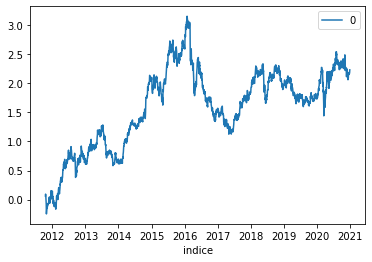

In [4]:
#----------------------------------------------------------------------------------------------
#  Guarda retorno dos portfolios otimizados
#----------------------------------------------------------------------------------------------   
    
df_ret_acao_per = pd.DataFrame()
df_ret_opt = pd.DataFrame()
itera = 0
acao = 0
t = janela_retornos
while t < T:
        
    retornos_aux = np.array(df_Retornos.iloc[(t+1):(t+janela_reb+1)])
    
    if itera > 0:
        w_novo = np.array(df_w.iloc[:,itera])
        df_ret_opt.iloc[len(df_ret_opt)-1,0] = df_ret_opt.iloc[len(df_ret_opt)-1,0] - np.abs(w_novo-w_aux).sum()*custo
    
    w_aux = np.array(df_w.iloc[:,itera])
        
    for i in range(0,retornos_aux.shape[0]):
            
        df_ret_opt = pd.concat([df_ret_opt, 
                                   pd.DataFrame(data=[(w_aux*retornos_aux[i,:]).sum()])], 
                                   axis = 0)
            
    itera = itera + 1    
    t = t + janela_reb

df_ret_opt.index = df_Retornos.index[(janela_retornos+1):len(df_Retornos.index)]
import seaborn as sns
sns.lineplot(data = df_ret_opt.cumsum())

df_ret_opt.to_csv(str_dir + 'MARKOWITZ.csv')
